In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

import plotly.offline as pyo
pyo.init_notebook_mode()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix,f1_score,ConfusionMatrixDisplay


# Data Preprocessing

In [30]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head(10)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   
5        Private          Urban             186.21  29.0  formerly smoked   
6        Private          Rural              70.09  27.4     never smoked   
7        Private          Urban              94.39  22.8     never smoked   
8        Private          Rural              76.15   NaN          Unknown   
9        Private          Urban              58.57  24.2          Unknown   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

With a quick look at our data, smoking_status has more than 2 categories which may be possible to generalise into 2 categories (smoked and never smoked)

In [31]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We have 12 rows, 11 features and 1 label.
However we can omit id as a feature. Hence we currently have 10 features to work with.

Numerical data: age, avg_glucose_level, BMI.

Categorical data: gender, hypertension, heart_disease, ever_married, work_type, residence_type, smoking_status, stroke.

In [32]:
# creating instance of labelencoder
le = LabelEncoder()
# Assigning numerical values and storing in another column
df['gender_Cat'] = le.fit_transform(df['gender'])
df['married_Cat'] = le.fit_transform(df['ever_married'])
df['worktype_Cat'] = le.fit_transform(df['work_type'])
df['Residence_type_Cat'] = le.fit_transform(df['Residence_type'])

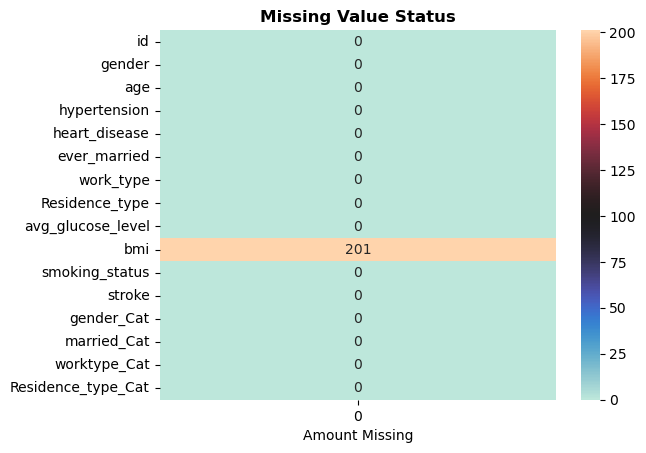

In [33]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='icefire')
ax.set_xlabel('Amount Missing')
plt.show()

# EDA

In [34]:
fig = ex.pie(df,names='stroke')
fig.update_layout(title='<b>Proportion Of stroke Samples<b>')
fig.show()


As to be seen, the dataset is very imbalanced.

We will need to deal with this imbalanced dataset later

In [35]:
fig = ex.pie(df,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Smoking Status Samples<b>')
fig.show()

In [36]:
len(df)


5110

Lets drop rows which has unknown smoking status.



In [37]:
df = df.drop(df[df['smoking_status']=='Unknown'].index)
len(df)


3566

In [38]:
fig = ex.pie(df,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Smoking Status Samples<b>')
fig.show()


Let us combine formerly smoked and never smokes to nonsmoker. As per clinical research on Stroke-
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7819918/

In [39]:
df.loc[(df['smoking_status'] == 'formerly smoked'), 'smoking_status'] = 'never smoked'

In [40]:
fig = ex.pie(df,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Smoking Status Samples<b>')
fig.show()

In [41]:
#Encode smoke data
df['smoking_status_Cat'] = le.fit_transform(df['smoking_status'])

Feature: BMI
Remember we had some missing values for BMI? Let us predict it with a simple regression model with age, gender, hypertension and avg_glucose_level to fill in the missing value instead of naively inputting it with the mean or median.



In [42]:
bmi_pipe = Pipeline( steps=[
                            ('scaler',StandardScaler()),
                            ('LinReg',LinearRegression())
                              ])
X = df[['age','avg_glucose_level','hypertension','bmi']].copy()


In [43]:
Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(bmi_pipe.predict(Missing[['age','avg_glucose_level','hypertension']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [44]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3566 entries, 0 to 5108
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3566 non-null   int64  
 1   gender              3566 non-null   object 
 2   age                 3566 non-null   float64
 3   hypertension        3566 non-null   int64  
 4   heart_disease       3566 non-null   int64  
 5   ever_married        3566 non-null   object 
 6   work_type           3566 non-null   object 
 7   Residence_type      3566 non-null   object 
 8   avg_glucose_level   3566 non-null   float64
 9   bmi                 3566 non-null   float64
 10  smoking_status      3566 non-null   object 
 11  stroke              3566 non-null   int64  
 12  gender_Cat          3566 non-null   int32  
 13  married_Cat         3566 non-null   int32  
 14  worktype_Cat        3566 non-null   int32  
 15  Residence_type_Cat  3566 non-null   int32  
 16  smoking_sta

In [45]:
bmi = list(df['bmi'].values)
hist_data = [bmi]
group_labels = ["bmi"]
colors = ['#1f77b4']
fig = ff.create_distplot(hist_data,group_labels,show_hist = True,colors=colors)
fig.update_layout({"template":"plotly_dark"})
fig.show()


Seems like we have outliers in BMI. We will deal with them later below.

# Feature: Gender


In [46]:
df["gender"].value_counts()


gender
Female    2158
Male      1407
Other        1
Name: count, dtype: int64

In [47]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3565 entries, 0 to 5108
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3565 non-null   int64  
 1   gender              3565 non-null   object 
 2   age                 3565 non-null   float64
 3   hypertension        3565 non-null   int64  
 4   heart_disease       3565 non-null   int64  
 5   ever_married        3565 non-null   object 
 6   work_type           3565 non-null   object 
 7   Residence_type      3565 non-null   object 
 8   avg_glucose_level   3565 non-null   float64
 9   bmi                 3565 non-null   float64
 10  smoking_status      3565 non-null   object 
 11  stroke              3565 non-null   int64  
 12  gender_Cat          3565 non-null   int32  
 13  married_Cat         3565 non-null   int32  
 14  worktype_Cat        3565 non-null   int32  
 15  Residence_type_Cat  3565 non-null   int32  
 16  smoking_sta

Summary of numerical features (.describe())


In [48]:
for i in ['age','avg_glucose_level', 'bmi']:
    print(df[i].describe())
    print("\n")


count    3565.000000
mean       48.860309
std        18.873140
min        10.000000
25%        34.000000
50%        50.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64


count    3565.000000
mean      108.972376
std        48.295550
min        55.120000
25%        77.460000
50%        92.650000
75%       116.670000
max       271.740000
Name: avg_glucose_level, dtype: float64


count    3565.000000
mean       30.321527
std         7.160116
min        11.500000
25%        25.400000
50%        29.385942
75%        33.900000
max        92.000000
Name: bmi, dtype: float64




Let us remove some outliers with the 1.5 IQR Rule.



In [49]:
IQR = df["avg_glucose_level"].quantile(0.75)-df["avg_glucose_level"].quantile(0.25)
upper = df["avg_glucose_level"].quantile(0.75)+1.5*IQR
lower = df["avg_glucose_level"].quantile(0.25)-1.5*IQR

IQR1 = df["bmi"].quantile(0.75)-df["bmi"].quantile(0.25)
upper1 = df["bmi"].quantile(0.75)+1.5*IQR1
lower1 = df["bmi"].quantile(0.25)-1.5*IQR1

index_out = df[(df["avg_glucose_level"]>upper) | (df["avg_glucose_level"]<lower) | (df["bmi"]>upper1) | (df["bmi"]<lower1) ].index
df.drop(index_out, inplace=True)


In [50]:
df.describe()


id          age  hypertension  heart_disease  \
count   2991.000000  2991.000000   2991.000000    2991.000000   
mean   36873.399866    46.978268      0.099967       0.048813   
std    21254.856077    18.798505      0.300006       0.215513   
min       67.000000    10.000000      0.000000       0.000000   
25%    18141.500000    32.000000      0.000000       0.000000   
50%    37545.000000    47.000000      0.000000       0.000000   
75%    55408.500000    61.000000      0.000000       0.000000   
max    72915.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke   gender_Cat  married_Cat  \
count        2991.000000  2991.000000  2991.000000  2991.000000  2991.000000   
mean           91.750461    29.258615     0.044801     0.386827     0.737546   
std            23.402486     5.972382     0.206902     0.487105     0.440042   
min            55.120000    14.100000     0.000000     0.000000     0.000000   
25%            74.870000    24.900000     0.000000     0.000000     0.000000   
50%            88.130000    28.700000     0.000000     0.000000     1.000000   
75%           103.850000    32.700000     0.000000     1.000000     1.000000   
max           175.290000    46.500000     1.000000     1.000000     1.000000   

       worktype_Cat  Residence_type_Cat  smoking_status_Cat  
count   2991.000000         2991.000000         2991.000000  
mean       1.917753            0.509863            0.225343  
std        0.925623            0.499986            0.417878  
min        0.000000            0.000000            0.000000  
25%        2.000000            0.000000            0.000000  
50%        2.000000            1.000000            0.000000  
75%        2.000000            1.000000            0.000000  
max        4.000000            1.000000            1.000000

In [51]:
bmi = list(df['bmi'].values)
hist_data = [bmi]
group_labels = ["bmi"]
colors = ['#1f77b4']
fig = ff.create_distplot(hist_data,group_labels,show_hist = True,colors=colors)
fig.update_layout({"template":"plotly_dark"})
fig.show()


BMI data seems much better now

Let us see the correlation matrices

Both Pearson and Spearman are used for measuring the correlation but the difference between them lies in the kind of analysis we want.

Pearson correlation: Pearson correlation evaluates the linear relationship between two continuous variables.

Spearman correlation: Spearman correlation evaluates the monotonic relationship, meaning relationship in which the variables tend to move in the same/opposite direction but not necessarily at a constant rate.

The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.



In [52]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming df is your DataFrame with both numeric and non-numeric columns

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64','int32'])

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Pearson Correlation', 
                                                                     'Spearman Correlation'))

s_val = numeric_df.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col, y=s_idx, z=s_val, name='pearson', showscale=False, xgap=1, ygap=1),
    row=1, col=1
)

s_val = numeric_df.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col, y=s_idx, z=s_val, xgap=1, ygap=1),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Correlations")
fig.show()


colours are not very distinct from one another, which is due to the imbalanced proportion of stroke samples. So we use coefficients (hover over the correlation matrices) to observe.

As to be seen, the numerical data that correlates most to stroke are age, hypertension, heart disease


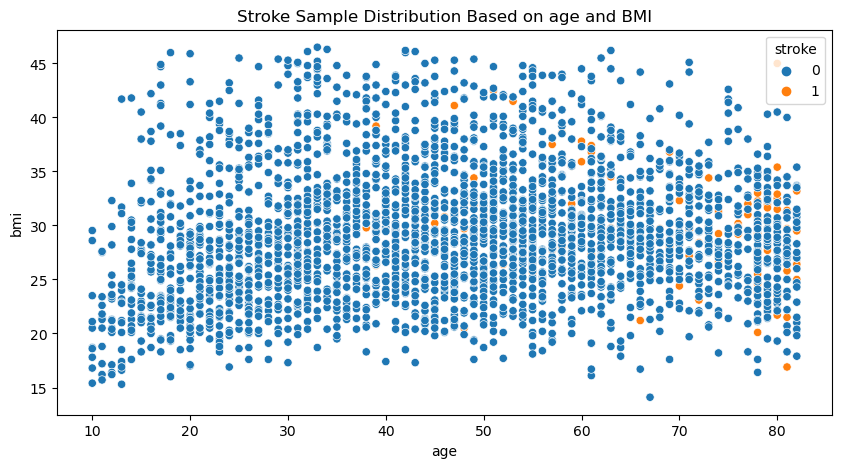

In [53]:
plt.figure(figsize=(10, 5))  # Adjust the width and height as needed

# Plot the scatter plot
plt.title('Stroke Sample Distribution Based on age and BMI')
sns.scatterplot(x=df['age'], y=df['bmi'], hue=df['stroke'])

# Show the plot
plt.show()


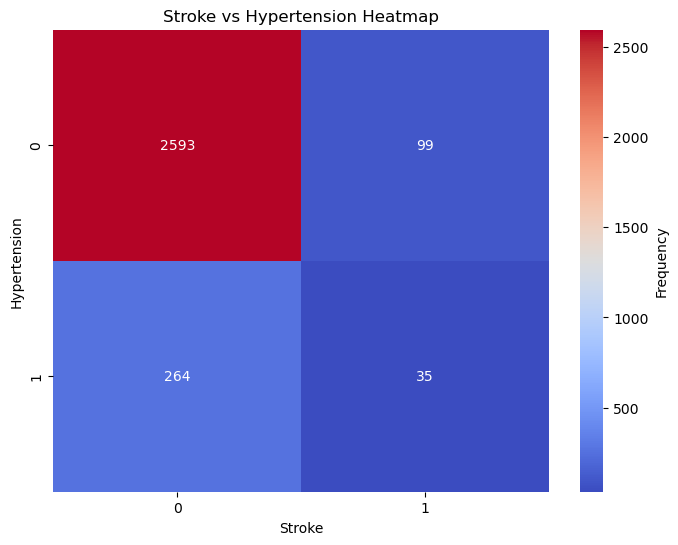

In [54]:
# Create a pivot table to prepare data for the heatmap
heatmap_data = df.pivot_table(index='hypertension', columns='stroke', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', cbar_kws={'label': 'Frequency'})

# Set labels and title
plt.title('Stroke vs Hypertension Heatmap')
plt.xlabel('Stroke')
plt.ylabel('Hypertension')

# Show the plot
plt.show()

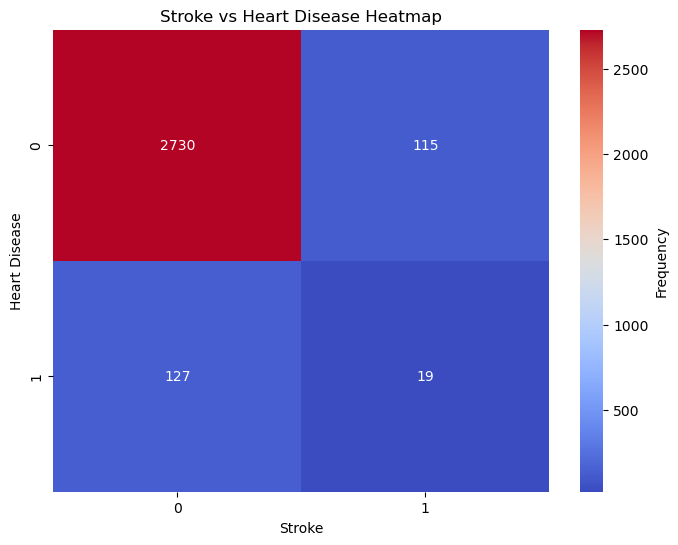

In [55]:
# Create a pivot table to prepare data for the heatmap
heatmap_data = df.pivot_table(index='heart_disease', columns='stroke', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', cbar_kws={'label': 'Frequency'})

# Set labels and title
plt.title('Stroke vs Heart Disease Heatmap')
plt.xlabel('Stroke')
plt.ylabel('Heart Disease')

# Show the plot
plt.show()

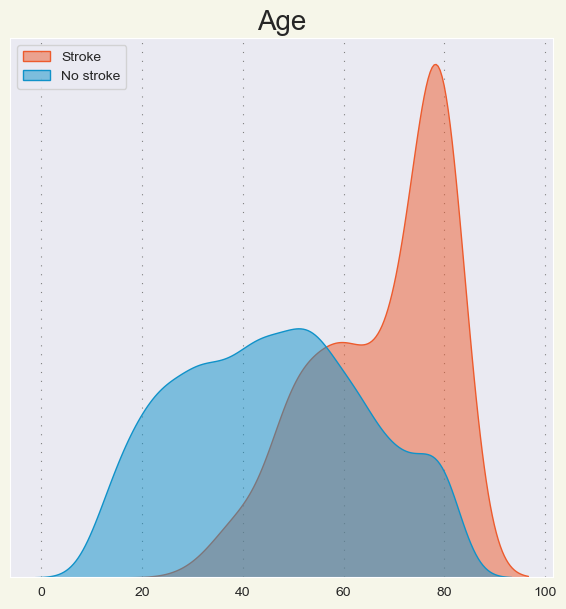

In [56]:
fig = plt.figure(figsize = (7, 7))
fig.patch.set_facecolor('#f6f6e9')

sns.set_style("dark")
plt.title('Age', size = 20)
sns.kdeplot(df.query('stroke == 1')['age'], color = '#ed5b2d', shade = True, label = 'Stroke', alpha = 0.5)
sns.kdeplot(df.query('stroke == 0')['age'], color = '#1092c9', shade = True, label = "No stroke", alpha = 0.5)
plt.grid(color = 'gray', linestyle = ':', axis = 'x', zorder = 0,  dashes = (1,7))
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.legend(loc = 'upper left')


KDE plot insights

The kde shows the density of the feature for each value of the target. There are usually 2 colored humps representing the 2 values of TARGET. If the humps are well-separated and non-overlapping, then there is a correlation with the TARGET. If the humps are overlapping a lot, then that means the feature is not well-correlated with the TARGET, because the TARGET is equally as common on those values of the feature.

above the age of 50, one is very likely to have hypertension especially above 60s. possible relationship between age and stroke.



# We now group the categorical features to increase interpretebility of data later.



In [57]:
stroke1 = df.copy()
# Create age groups
stroke1['age_group'] = 0
for i in range(len(stroke1.index)):
    if stroke1.iloc[i, 2] < 2:
        stroke1.iloc[i, 17] = 'baby'
    elif stroke1.iloc[i, 2] < 17 and stroke1.iloc[i, 2] >= 2:
        stroke1.iloc[i, 17] = 'child'
    elif stroke1.iloc[i, 2] < 30 and stroke1.iloc[i, 2] >= 17:
        stroke1.iloc[i, 17] = 'young adults'
    elif stroke1.iloc[i, 2] < 60 and stroke1.iloc[i, 2] >= 30:
        stroke1.iloc[i, 17] = 'middle-aged adults'
    elif stroke1.iloc[i, 2] < 80 and stroke1.iloc[i, 2] >= 60:
        stroke1.iloc[i, 17] = 'old-aged adults'
    else:
        stroke1.iloc[i, 17] = 'long-lived'
        
# Create bmi groups
stroke1['bmi_group'] = 0
for i in range(len(stroke1.index)):
    if stroke1.iloc[i, 9] < 18.5:
        stroke1.iloc[i, 18] = 'Underweight'
    elif stroke1.iloc[i, 9] < 25.0 and stroke1.iloc[i, 9] >= 18.5:
        stroke1.iloc[i, 18] = 'Normal weight'
    elif stroke1.iloc[i, 9] < 30.0 and stroke1.iloc[i, 9] >= 25.0:
        stroke1.iloc[i, 18] = 'Overweight'
    else:
        stroke1.iloc[i, 18] = 'Obese'
        
# Create glucose groups
stroke1['glucose_group'] = 0
for i in range(len(stroke1.index)):
    if stroke1.iloc[i, 8] < 100:
        stroke1.iloc[i, 19] = 'Normal'
    elif stroke1.iloc[i, 8] >= 100 and stroke1.iloc[i, 8] < 125:
        stroke1.iloc[i, 19] = 'Prediabetes'
    else:
        stroke1.iloc[i, 19] = 'Diabetes'


In [58]:
# Grouping by categorical features
dst_st_age = stroke1.groupby(['age_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
heart = stroke1.groupby(['heart_disease', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
marry = stroke1.groupby(['ever_married', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
work = stroke1.groupby(['work_type', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
residence = stroke1.groupby(['Residence_type', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
glucose_group = stroke1.groupby(['glucose_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
bmi_group = stroke1.groupby(['bmi_group', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()
smoking = stroke1.query('smoking_status != "Unknown"').groupby(['smoking_status', 'stroke']).agg({'stroke': 'count'})\
.rename(columns = {'stroke': 'count'}).reset_index()
hypertension0 = marry = stroke1.groupby(['hypertension', 'stroke']).agg({'stroke': 'count'}).rename(columns = {'stroke': 'count'}).reset_index()


# Create percent column for data frames
def percent(data):
    data['percent'] = 0
    for i in range(len(data.index)):
        if i < len(data.index)-1:
            if data.iloc[i, 0] == data.iloc[i+1, 0]:
                data.iloc[i, 3] = round((data.iloc[i, 2] / (data.iloc[i, 2] + data.iloc[i+1, 2])) * 100, 1)
            elif data.iloc[i, 0] == data.iloc[i-1, 0]:
                data.iloc[i, 3] = 100 - data.iloc[i-1, 3]
            else:
                data.iloc[i, 3] = 100.0
        else:
            if data.iloc[i, 0] == data.iloc[i-1, 0]:
                data.iloc[i, 3] = 100 - data.iloc[i-1, 3]
            else:
                data.iloc[i, 3] = 100.0
            
percent(dst_st_age)
percent(heart)
percent(marry)
percent(work)
percent(residence)
percent(glucose_group)
percent(bmi_group)
percent(smoking)
percent(hypertension0)

In [59]:
bmi_group.head(10)


bmi_group  stroke  count  percent
0  Normal weight       0    679     96.3
1  Normal weight       1     26      3.7
2          Obese       0   1150     95.6
3          Obese       1     53      4.4
4     Overweight       0    983     94.8
5     Overweight       1     54      5.2
6    Underweight       0     45     97.8
7    Underweight       1      1      2.2

In [60]:
stroke1.head(20)

id  gender   age  hypertension  heart_disease ever_married  \
2   31112    Male  80.0             0              1          Yes   
3   60182  Female  49.0             0              0          Yes   
4    1665  Female  79.0             1              0          Yes   
6   53882    Male  74.0             1              1          Yes   
7   10434  Female  69.0             0              0           No   
10  12109  Female  81.0             1              0          Yes   
11  12095  Female  61.0             0              1          Yes   
12  12175  Female  54.0             0              0          Yes   
15  58202  Female  50.0             1              0          Yes   
18  27458  Female  60.0             0              0           No   
24   4219    Male  71.0             0              0          Yes   
25  70822    Male  80.0             0              0          Yes   
26  38047  Female  65.0             0              0          Yes   
34  14248    Male  48.0             0              0           No   
35    712  Female  82.0             1              1           No   
37  24977  Female  72.0             1              0          Yes   
39  62602  Female  49.0             0              0          Yes   
40   4651    Male  78.0             0              0          Yes   
41   1261    Male  54.0             0              0          Yes   
42  61960    Male  82.0             0              1          Yes   

        work_type Residence_type  avg_glucose_level   bmi smoking_status  \
2         Private          Rural             105.92  32.5   never smoked   
3         Private          Urban             171.23  34.4         smokes   
4   Self-employed          Rural             174.12  24.0   never smoked   
6         Private          Rural              70.09  27.4   never smoked   
7         Private          Urban              94.39  22.8   never smoked   
10        Private          Rural              80.43  29.7   never smoked   
11       Govt_job          Rural             120.46  36.8         smokes   
12        Private          Urban             104.51  27.3         smokes   
15  Self-employed          Rural             167.41  30.9   never smoked   
18        Private          Urban              89.22  37.8   never smoked   
24        Private          Urban             102.87  27.2   never smoked   
25  Self-employed          Rural             104.12  23.5   never smoked   
26        Private          Rural             100.98  28.2   never smoked   
34       Govt_job          Urban              84.20  29.7   never smoked   
35        Private          Rural              84.03  26.5   never smoked   
37        Private          Rural              74.63  23.1   never smoked   
39        Private          Urban              60.91  29.9   never smoked   
40        Private          Rural              78.03  23.9   never smoked   
41        Private          Urban              71.22  28.5   never smoked   
42        Private          Urban             144.90  26.4         smokes   

    stroke  gender_Cat  married_Cat  worktype_Cat  Residence_type_Cat  \
2        1           1            1             2                   0   
3        1           0            1             2                   1   
4        1           0            1             3                   0   
6        1           1            1             2                   0   
7        1           0            0             2                   1   
10       1           0            1             2                   0   
11       1           0            1             0                   0   
12       1           0            1             2                   1   
15       1           0            1             3                   0   
18       1           0            0             2                   1   
24       1           1            1             2                   1   
25       1           1            1             3                   0   
26       1 

In [61]:
dst_st_age


age_group  stroke  count  percent
0               child       0    132    100.0
1          long-lived       0     87     77.7
2          long-lived       1     25     22.3
3  middle-aged adults       0   1498     97.5
4  middle-aged adults       1     39      2.5
5     old-aged adults       0    639     90.1
6     old-aged adults       1     70      9.9
7        young adults       0    501    100.0

# Barplots

In [62]:
dst_st_age.iloc[[2,4,6], 1] = "Had Stroke"
dst_st_age.iloc[[0,1,3,5,7], 1] = "Didn't have Stroke"

hypertension0.iloc[[0,1], 0] = 'N`o Hypertension'
hypertension0.iloc[[2,3], 0] = 'Hypertension'

heart.iloc[[0,1], 0] = 'No heart diseases'
heart.iloc[[2,3], 0] = 'Heart diseases'



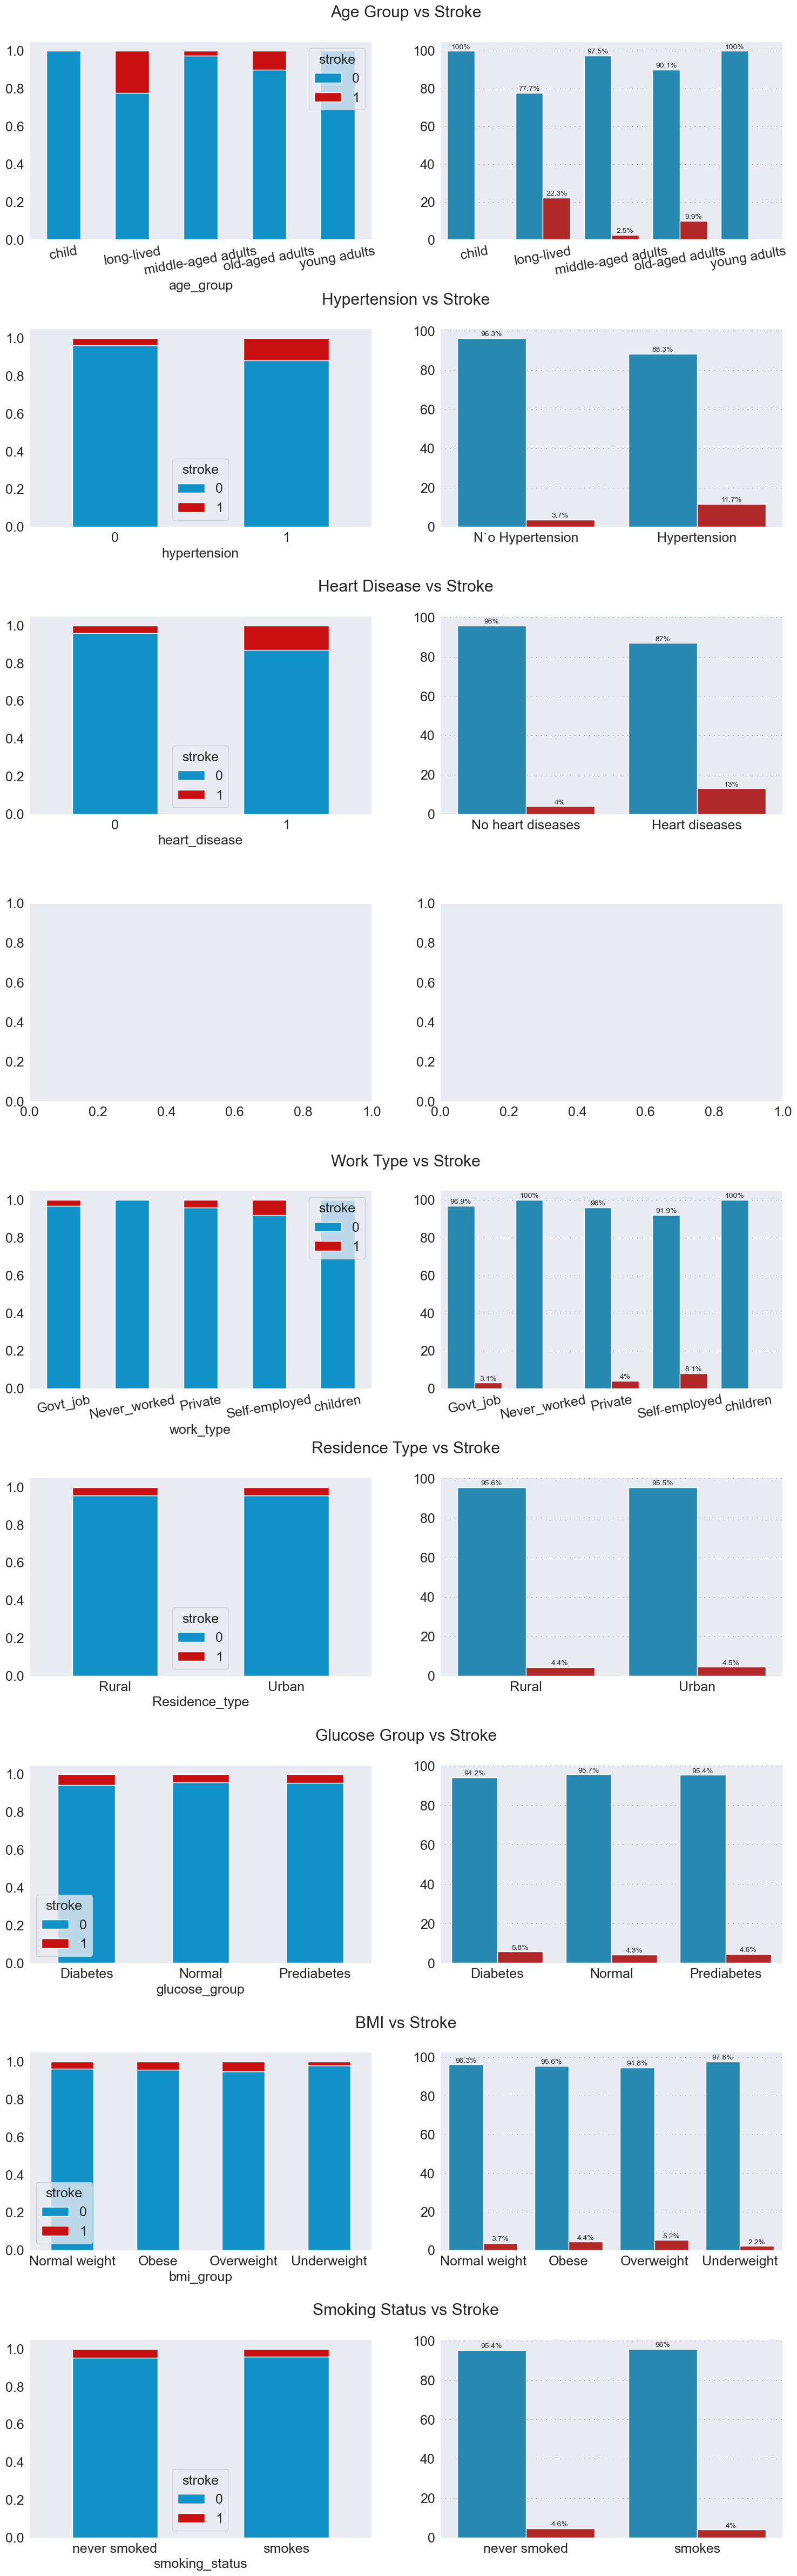

In [63]:
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams.update({'font.size': 18})
ax.tick_params(labelrotation=45)
fig.tight_layout()
fig.patch.set_facecolor('#fafafa')
f, axes = plt.subplots(9, 2, figsize=(18,60))
f.subplots_adjust(hspace=.45)


table=pd.crosstab(stroke1.age_group,stroke1.stroke)
a=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[0,0],  color = ['#1092c9','#c91010'],rot = 10)
axes[0,0].set_title('Age Group vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,2)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
a2 = sns.barplot(data = dst_st_age, x = dst_st_age['age_group'], y = dst_st_age['percent'], hue = dst_st_age['stroke'], palette = ['#1092c9','#c91010',])
plt.xticks(rotation = 10)
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

##########

table=pd.crosstab(stroke1.hypertension, stroke1.stroke)
b=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[1,0],  color = ['#1092c9','#c91010',],rot=0)
axes[1,0].set_title('Hypertension vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,4)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
b2 = sns.barplot(data = hypertension0, x = hypertension0['hypertension'], y = hypertension0['percent'], hue = hypertension0['stroke'], palette = ['#1092c9','#c91010',])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

##########

table=pd.crosstab(stroke1.heart_disease, stroke1.stroke)
c=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[2,0], color = ['#1092c9','#c91010',],rot=0)
axes[2,0].set_title('Heart Disease vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,6)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
c2 = sns.barplot(data = heart, x = heart['heart_disease'], y = heart['percent'], hue = heart['stroke'], palette = ['#1092c9','#c91010',])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

##########
table=pd.crosstab(stroke1.work_type, stroke1.stroke)
e=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[4,0], color = ['#1092c9','#c91010',],rot=10)
axes[4,0].set_title('Work Type vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,10)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
e2 = sns.barplot(data = work, x = work['work_type'], y = work['percent'], hue = work['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation = 10)
plt.legend('').set_visible(False)
##########
table=pd.crosstab(stroke1.Residence_type, stroke1.stroke)
f=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[5,0], color = ['#1092c9','#c91010',],rot=0)
axes[5,0].set_title('Residence Type vs Stroke', y=1.1 , x=1.1)
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)

plt.subplot(9,2,12)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
f2 = sns.barplot(data = residence, x = residence['Residence_type'], y = residence['percent'], hue = residence['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)
##########

table=pd.crosstab(stroke1.glucose_group, stroke1.stroke)
g=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[6,0], color = ['#1092c9','#c91010'],rot=0)
axes[6,0].set_title('Glucose Group vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,14)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
g2 = sns.barplot(data = glucose_group, x = glucose_group['glucose_group'], y = glucose_group['percent'], hue = glucose_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)
##########
table=pd.crosstab(stroke1.bmi_group, stroke1.stroke)
h=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[7,0],color = ['#1092c9','#c91010'],rot=0)
axes[7,0].set_title('BMI vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,16)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
h2 = sns.barplot(data = bmi_group, x = bmi_group['bmi_group'], y = bmi_group['percent'], hue = bmi_group['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)
##########
table=pd.crosstab(stroke1.smoking_status, stroke1.stroke)
j=table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax = axes[8,0],color = ['#1092c9','#c91010'],rot=0)
axes[8,0].set_title('Smoking Status vs Stroke', y=1.1 , x=1.1)
plt.subplot(9,2,18)
plt.grid(color = 'gray', linestyle = ':', axis = 'y', zorder = 0,  dashes = (1,7))
j2 = sns.barplot(data = smoking, x = smoking['smoking_status'], y = smoking['percent'], hue = smoking['stroke'], palette = ['#1092c9','#c91010'])
plt.ylabel('')
plt.xlabel('')
plt.legend('').set_visible(False)
##########
# add annotations

for i in [a2,b2,c2,e2,f2,g2,h2,j2]:
    for p in i.patches:
        height = p.get_height()
        i.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size = 10,
                   xytext = (0, 5), 
                   textcoords = 'offset points')
        
plt.show()



based on barplots


Age Group

long-lived and middle-aged adults are more likely to have stroke.
strong correlation between age group and stroke.
Stroke and Heart Diseases
strong correlation between stroke and hypertension.

However, this can still happen to those who did not have hypertension or heart diseases given available data.


Work Type
percentages for govt job, private and self-employed are very similar.
note that the data is very imbalanced. (alot of private, everything else very little)
hard to check relationship as there are only 14 who never worked, which is a stark difference in data amount compared to the rest.

Residence Type
residence type do not seem to affect since the percentages are quite similar.
not much correlation.

Glucose Group
those with diabetes are more likely to have stroke.
strong correlation between glucose levels and stroke.

BMI
those who are obese are more likely to have stroke.
strong correlation between BMI and stroke.

Smoking
smoking do not seem to affect since the percentages are quite similar.
not much correlation.

Let's take a closer look at the effect of age on stroke.



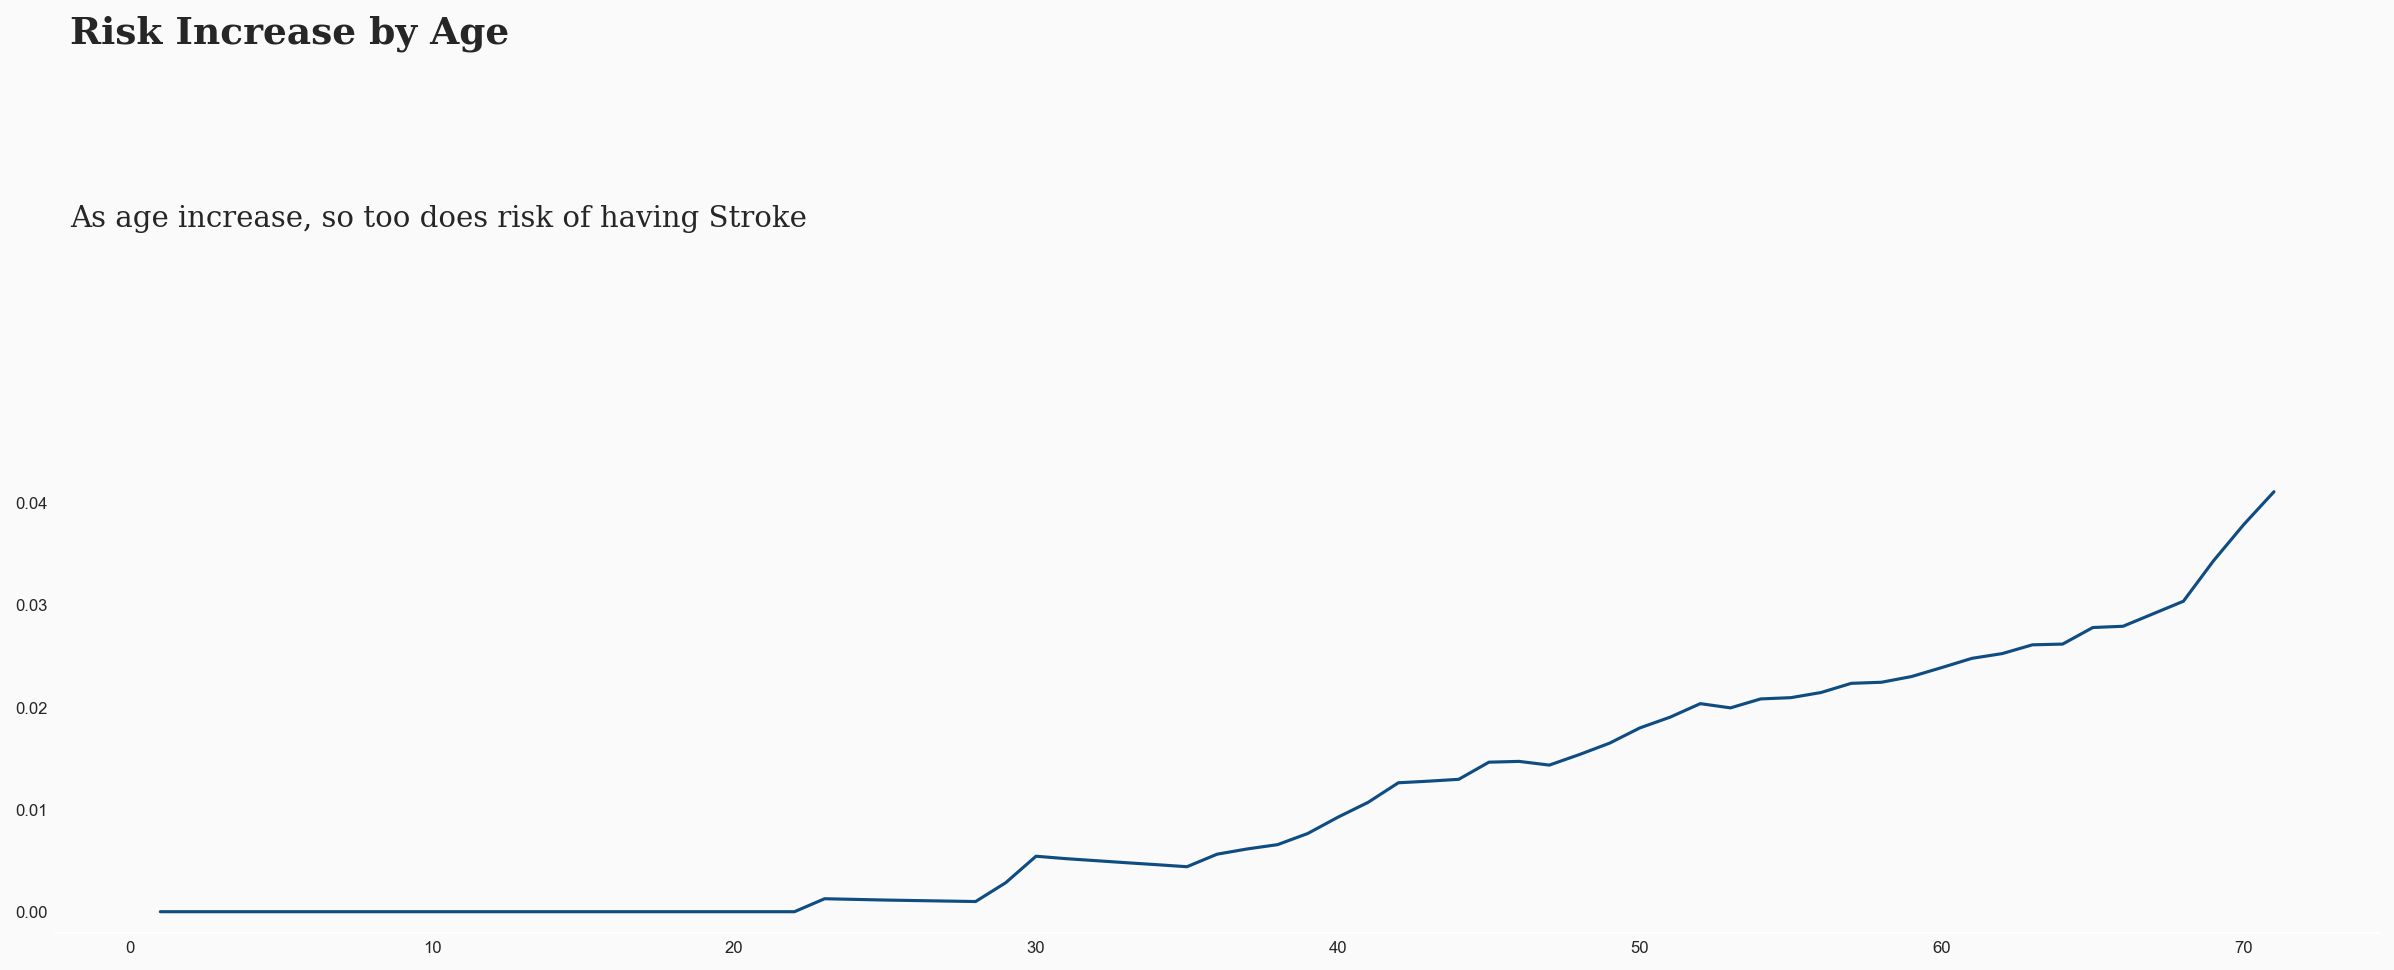

In [64]:
background_color = "#fafafa"
fig = plt.figure(figsize=(20, 10), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)


df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke']))

sns.lineplot(data=rate,color='#0f4c81',ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(-2,0.085,'Risk Increase by Age',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-2,0.067,'As age increase, so too does risk of having Stroke',fontsize=14,fontfamily='serif')


plt.show()


#  Stroke

In [65]:
df['stroke'].value_counts()

stroke
0    2857
1     134
Name: count, dtype: int64

<font color=' red'><font size="3"><a href='#2'>As mentioned earlier, we have an imbalanced data.</a><br /><br />
<font color=' red'><font size="3">Traditional machine learning algorithms, like decision trees and logistic regression, struggle with imbalanced datasets. These methods prioritize the majority class, leading to poor performance in identifying the minority class.
    
<font color=' red'><font size="3"> To address this issue, a technique called SMOTE (Synthetic Minority Over-sampling Technique) can be used. SMOTE is a popular resampling method that helps balance the dataset by creating synthetic samples for the minority class.

<font color=green><font size="3">First we Standardise the data

In [66]:
df1 = df.copy()
X=df1.copy().drop(['stroke','id', 'gender','ever_married', 'work_type','Residence_type','smoking_status'],axis=1)
Y=df1['stroke']

In [67]:
  
X[['age','avg_glucose_level','bmi']] = StandardScaler().fit_transform(X[['age','avg_glucose_level','bmi']])
X.head()

age  hypertension  heart_disease  avg_glucose_level       bmi  \
2  1.756908             0              1           0.605573  0.542820   
3  0.107565             0              0           3.396769  0.861004   
4  1.703704             1              0           3.520280 -0.880636   
6  1.437681             1              1          -0.925717 -0.311254   
7  1.171658             0              0           0.112808 -1.081594   

   gender_Cat  married_Cat  worktype_Cat  Residence_type_Cat  \
2           1            1             2                   0   
3           0            1             2                   1   
4           0            1             3                   0   
6           1            1             2                   0   
7           0            0             2                   1   

   smoking_status_Cat  
2                   0  
3                   1  
4                   0  
6                   0  
7                   0

In [68]:
Y.head()

2    1
3    1
4    1
6    1
7    1
Name: stroke, dtype: int64

# SMOTE (Synthetic Minority Over-sampling Technique)

<font color='blue'><font size="5">We first split the data into train and test sets then use the synthetic minority sampling technique

In [69]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_balanced, X_test, Y_balanced, Y_test = train_test_split(X,Y, test_size = 0.2)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_balanced, Y_balanced)

X_train_balanced_list=X_train_balanced.columns.values.tolist()

print(X_train_balanced_list)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Cat', 'married_Cat', 'worktype_Cat', 'Residence_type_Cat', 'smoking_status_Cat']


In [70]:
X_train_balanced.shape

(4574, 10)

In [71]:
from collections import Counter
print(Counter(Y_train_balanced))
print(Counter(Y_test))

Counter({0: 2287, 1: 2287})
Counter({0: 570, 1: 29})


<font color='blue'><font size="5">The training data is now balanced and standardised!

In [72]:
X_train_balanced.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  4574.000000   4574.000000    4574.000000        4574.000000   
mean      0.496450      0.122650       0.034762           0.055408   
std       1.001377      0.328071       0.183196           1.036818   
min      -1.967414      0.000000       0.000000          -1.565500   
25%      -0.211662      0.000000       0.000000          -0.677198   
50%       0.635052      0.000000       0.000000          -0.153875   
75%       1.428915      0.000000       0.000000           0.596031   
max       1.863318      1.000000       1.000000           3.570283   

               bmi   gender_Cat  married_Cat  worktype_Cat  \
count  4574.000000  4574.000000  4574.000000   4574.000000   
mean     -0.001093     0.338872     0.796021      2.025798   
std       0.856800     0.473378     0.402998      0.831923   
min      -2.538543     0.000000     0.000000      0.000000   
25%      -0.562452     0.000000     1.000000      2.000000   
50%      -0.026563     0.000000     1.000000      2.000000   
75%       0.422919     1.000000     1.000000      2.000000   
max       2.887335     1.000000     1.000000      4.000000   

       Residence_type_Cat  smoking_status_Cat  
count         4574.000000         4574.000000  
mean             0.459554            0.162659  
std              0.498416            0.369094  
min              0.000000            0.000000  
25%              0.000000            0.000000  
50%              0.000000            0.000000  
75%              1.000000            0.000000  
max              1.000000            1.000000

<a id='4'></a>
<div>
<img src="HeaderImages/Modeling.png" width="500"/>
</div>

<font color='blood red'><font size="5">What should we focus on?

- <font color='blood red'><font size="3"> Precision = (True Positive) / (Total predicted positive)
   
- <font color='blood red'><font size="3"> Recall = (True Positive) / (True Positive + False Negative)

- <font color='blood red'><font size="3"> F1 = 2* ( precision * recall) / (precision + recall)

<font color='blood red'><font size="4"> Since we are predicting stroke, the impact of False Negatives are much more undesirable as compared to False Positives. <font color=#191970><font size="4">It is worse for a patient to be predicted to not have a stroke then have one. Thus it makes sense to focus more on Recall instead of other metrics.

<font color='blood red'><font size="4"> However, precision can tell us how accurate/precise our model is out of those predicted positive, how many are actual positive, which is an important aspect too.

<font color='blood red'><font size="4"> F1 score allows us to seek a balance between Precision and Recall. While it may seem like a good measure, this means that we are compromising on Recall.
    
<font color=#FF4500><font size="5">
Hence, we focus on <font color=#FF69B4><font size="5">Recall</font><font color=#FF4500> scores where stroke=1.
    


<font color=green><font size="4">Wikipedia:<br>
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.<br><br>
Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1".

<font color=#8B4513><font size="4">First we use feature selection method<font color=#4169E1><font size="4"> RFE (Recursive Feature Elimination)<font color=#8B4513><font size="4"> to deduce the more important features by reoving the weakest features. We select n=4 features in this case.

In [73]:
import shap
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=600)
rfe = RFE(estimator=model, n_features_to_select=4)
fit = rfe.fit(X_train_balanced, Y_train_balanced)
print("Num Features: %s" % (fit.n_features_))
features = {'Features': X_train_balanced_list,'Selected Features':fit.support_ ,'Feature Ranking':fit.ranking_}
rfe_df = pd.DataFrame(features)
rfe_df

Num Features: 4


Features  Selected Features  Feature Ranking
0                 age               True                1
1        hypertension              False                2
2       heart_disease               True                1
3   avg_glucose_level              False                6
4                 bmi              False                5
5          gender_Cat               True                1
6         married_Cat              False                4
7        worktype_Cat              False                7
8  Residence_type_Cat              False                3
9  smoking_status_Cat               True                1

In [74]:
df = pd.concat([X_train_balanced, Y_train_balanced],axis = 1)

<font color='blacl'><font size="4">Features picked by RFE:<font color=#9370DB> age, married, heart_disease, gender type<br /><br />

## Classification report with model wrapped with RFE (4 features):

In [75]:
Y_pred = fit.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       570
           1       0.13      0.83      0.23        29

    accuracy                           0.73       599
   macro avg       0.56      0.77      0.53       599
weighted avg       0.95      0.73      0.80       599



## Classification report with standard model with all features:

In [76]:
fit1 = model.fit(X_train_balanced, Y_train_balanced)
Y_pred1 = fit1.predict(X_test)
print(classification_report(Y_test, Y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       570
           1       0.12      0.76      0.20        29

    accuracy                           0.71       599
   macro avg       0.55      0.73      0.51       599
weighted avg       0.94      0.71      0.79       599



### Feature importance from coefficient size:

In [77]:
ft_imp = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(10))
for i in range(len(ft_imp.index)):
    ft_imp.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
ft_imp['importance (abs coef)'] = abs(model.coef_)[0]
ft_imp = ft_imp.sort_values('importance (abs coef)', ascending = False)
ft_imp[0:12].style.background_gradient(cmap = 'Blues')

<font color='blood red'><font size="4">As to be seen, the 4 most important features in this case are: <font color=#9370DB>age, heart disease, gender and married .<br><br>
<font color='blood red'><font size="4">As compared to the one's selcted by RFE, the common features are: <font color=#7D6608><font size="4">age, heart disease, gender and married same as RFE.

## Confusion matrix of model with all features: 

<Axes: >

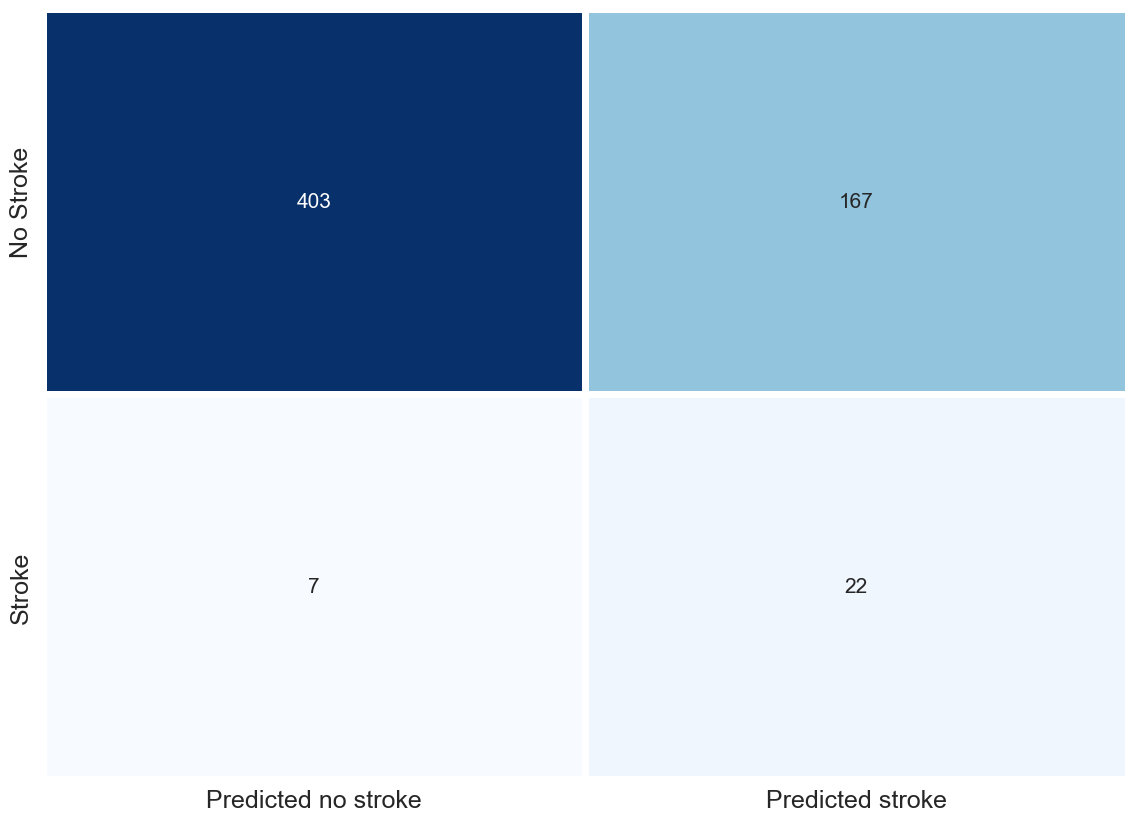

In [78]:
plt.rcParams['figure.figsize'] = 14, 10
lr_cm = confusion_matrix(Y_test, Y_pred1)
sns.heatmap(lr_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])

<font color='blood red'><font size="5">as seen from our classification report,
- <font color='blood red'><font size="4"> Recall score is mediocre.

# Decision Tree

<font color='blood red'><font size="5">Prior to predicting stroke with random forest, a simple decision tree model will first be observed.

<font color=#228B22><font size="4">A Decision Tree is a supervised machine learning algorithm that can be used for both classification and regression problems. A decision tree is simply a series of sequential decisions made to reach a specific result.<br><br>
 But often, a single tree is not sufficient for producing effective results. <br><br>
 Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions.<br><br>
 The Random Forest Algorithm combines the output of multiple (randomly created) Decision Trees to generate the final output.

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
#constructing a tree 
tree_dpt = DecisionTreeClassifier()

## Grid Search to determine best hyperparameters 

<font color='green'><font size="4">Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.

In [80]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid = GridSearchCV(tree_dpt, tree_param, scoring='recall')
grid.fit(X_train_balanced,Y_train_balanced)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 11}

### Using criterion = 'gini' and max_depth=120

In [81]:
tree_dpt2 = DecisionTreeClassifier(criterion='gini',max_depth = 120)
tree_dpt2.fit(X_train_balanced, Y_train_balanced)

DecisionTreeClassifier(max_depth=120)

In [82]:
from sklearn.tree import plot_tree

Scroll down in the cell to see decison tree figure

[Text(0.3195300486731151, 0.98, 'age <= -0.105\ngini = 0.5\nsamples = 4574\nvalue = [2287, 2287]\nclass = N'),
 Text(0.06349206349206349, 0.94, 'age <= -0.477\ngini = 0.177\nsamples = 1271\nvalue = [1146, 125]\nclass = N'),
 Text(0.019365079365079366, 0.9, 'age <= -0.737\ngini = 0.049\nsamples = 872\nvalue = [850, 22]\nclass = N'),
 Text(0.011428571428571429, 0.86, 'age <= -0.824\ngini = 0.006\nsamples = 680\nvalue = [678, 2]\nclass = N'),
 Text(0.008888888888888889, 0.82, 'gini = 0.0\nsamples = 603\nvalue = [603, 0]\nclass = N'),
 Text(0.013968253968253968, 0.82, 'avg_glucose_level <= -0.655\ngini = 0.051\nsamples = 77\nvalue = [75, 2]\nclass = N'),
 Text(0.011428571428571429, 0.78, 'avg_glucose_level <= -0.677\ngini = 0.172\nsamples = 21\nvalue = [19, 2]\nclass = N'),
 Text(0.008888888888888889, 0.74, 'gini = 0.0\nsamples = 19\nvalue = [19, 0]\nclass = N'),
 Text(0.013968253968253968, 0.74, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Y'),
 Text(0.01650793650793651, 0.78, 'gini 

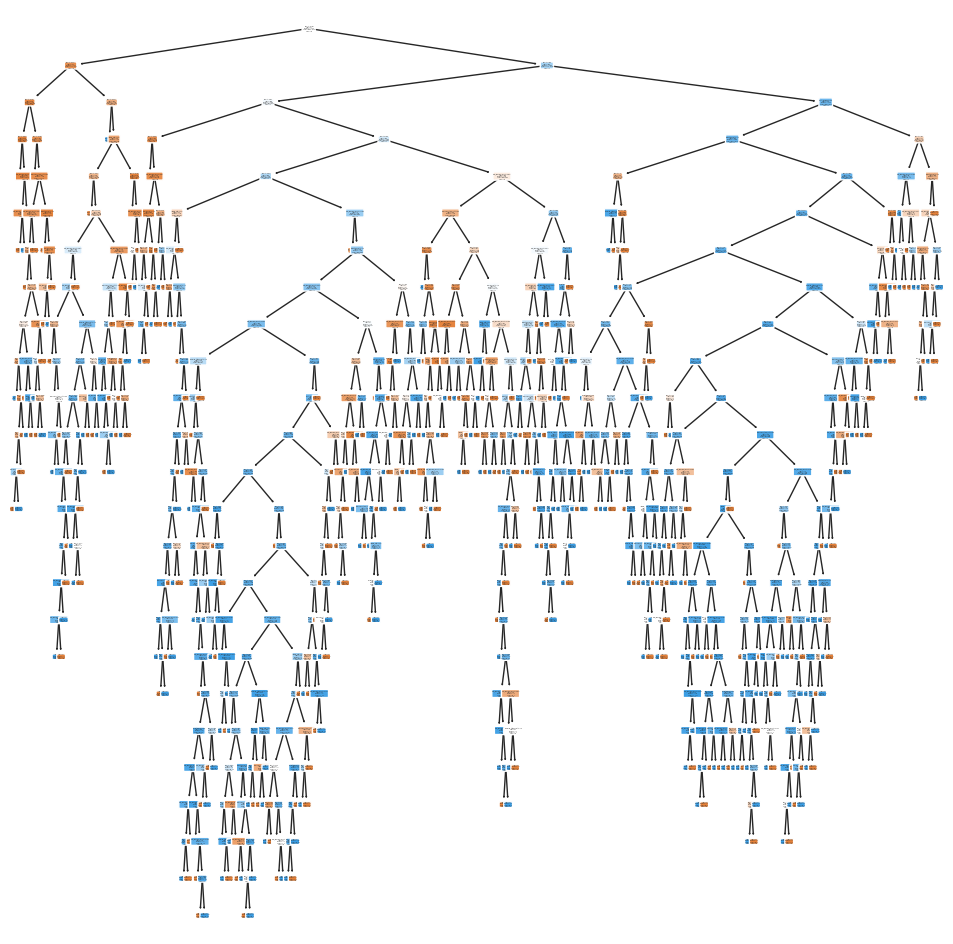

In [83]:
f = plt.figure(figsize=(12, 12))
plot_tree(tree_dpt2, filled=True, rounded=True,
          feature_names=X_train_balanced.columns.to_list(),  # Convert Index to list
          class_names=["N", "Y"])

<a id='4.21'><a>

In [84]:
Y_pred = tree_dpt2.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91       570
           1       0.05      0.14      0.07        29

    accuracy                           0.83       599
   macro avg       0.50      0.50      0.49       599
weighted avg       0.91      0.83      0.87       599



<font color='blood red'><font size="5">as seen from our classification report,
- <font color='blood red'><font size="4"> Recall for stroke = 1 is bad, but for stroke = 0 is quite good

In [85]:
f_imp1 = pd.DataFrame(columns = ['feature', 'importance'], index = range(10))
for i in range(len(f_imp1.index)):
    f_imp1.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp1['importance'] =tree_dpt2.feature_importances_
f_imp1 = f_imp1.sort_values('importance', ascending = False)
f_imp1[0:12].style.background_gradient(cmap = 'Blues')

<font color='blood red'><font size="4">For this Decision Tree, the 2 most important features in this case are: <font color=#9370DB>age and bmi.<br><br>

## Confusion Matrix 

<Axes: >

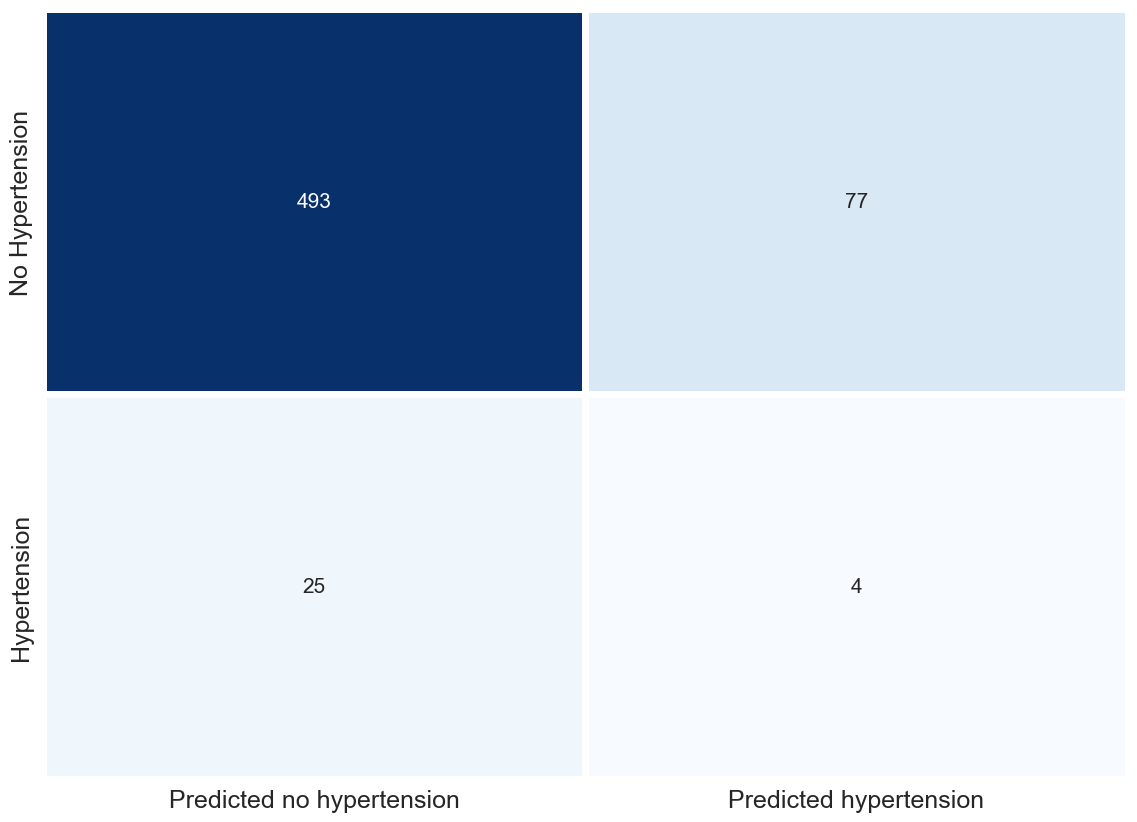

In [86]:
y_pred = tree_dpt2.predict(X_test)

dt_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(dt_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Hypertension', 'Hypertension'], xticklabels = ['Predicted no hypertension', 'Predicted hypertension'])


<a id='4.3'></a>
<div>
<img src="HeaderImages/RandomForest.png" width="500"/>
</div>

# Random Forest

In [87]:
from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [88]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10)
fit = model.fit(X_train_balanced, Y_train_balanced)


## GridSearch to determine best hyperparameters 

<font color='green'><font size="4">Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.


In [89]:
grid = GridSearchCV(rfc,param_grid, scoring='recall')

In [90]:
grid.fit(X_train_balanced,Y_train_balanced)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=10),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 5, 7],
                         'n_estimators': [64, 100, 128, 200]},
             scoring='recall')

In [91]:
grid.best_params_

{'bootstrap': True, 'max_features': 7, 'n_estimators': 200}

The 'best' hyperparameters are bootstrap=True, max_features=3, n_estimators=200

In [92]:
rfc = RandomForestClassifier(max_features=3,n_estimators=200,bootstrap=True)

In [93]:
rfc.fit(X_train_balanced,Y_train_balanced)

RandomForestClassifier(max_features=3, n_estimators=200)

In [94]:
rfc.score(X_test, Y_test)

0.8631051752921536

In [95]:
y_pred=rfc.predict(X_test)

## Feature importance from Random Forest Classifier:

In [96]:
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(10))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp2['importance'] =rfc.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

<font color=#800080><font size="4">Random Forest picked up: <font color=#800000><font size="4">age, bmi and average glucose level <font color=#800080><font size="4">as top important features. <br>


## Using SHAP 

<font color=#9370DB><font size=4>SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2017) is a method to explain individual predictions. <br>
    
<font color='Purple'><font size=4>  The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory.

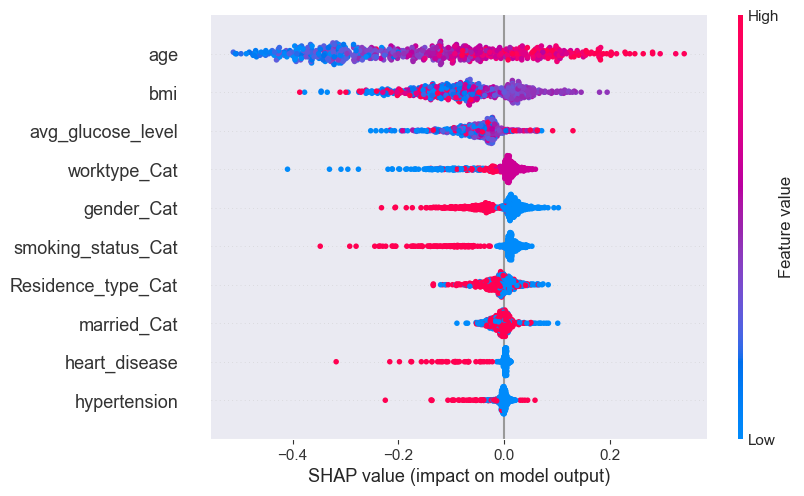

In [97]:
import copy

sample = shap.sample(X_train_balanced, 100)
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

shap_values1 = explainer(X_test)
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

shap.plots.beeswarm(shap_values2)


<font color=purple><font size="4"> SHAP has also picked up  <font color=blue><font size="4">age, bmi and avg_glucose level <font color=purple><font size="4">as the 3 most important features.</font>

### Classification Report 

In [98]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       570
           1       0.07      0.14      0.09        29

    accuracy                           0.86       599
   macro avg       0.51      0.52      0.51       599
weighted avg       0.91      0.86      0.89       599



## Confusion matrix 

<Axes: >

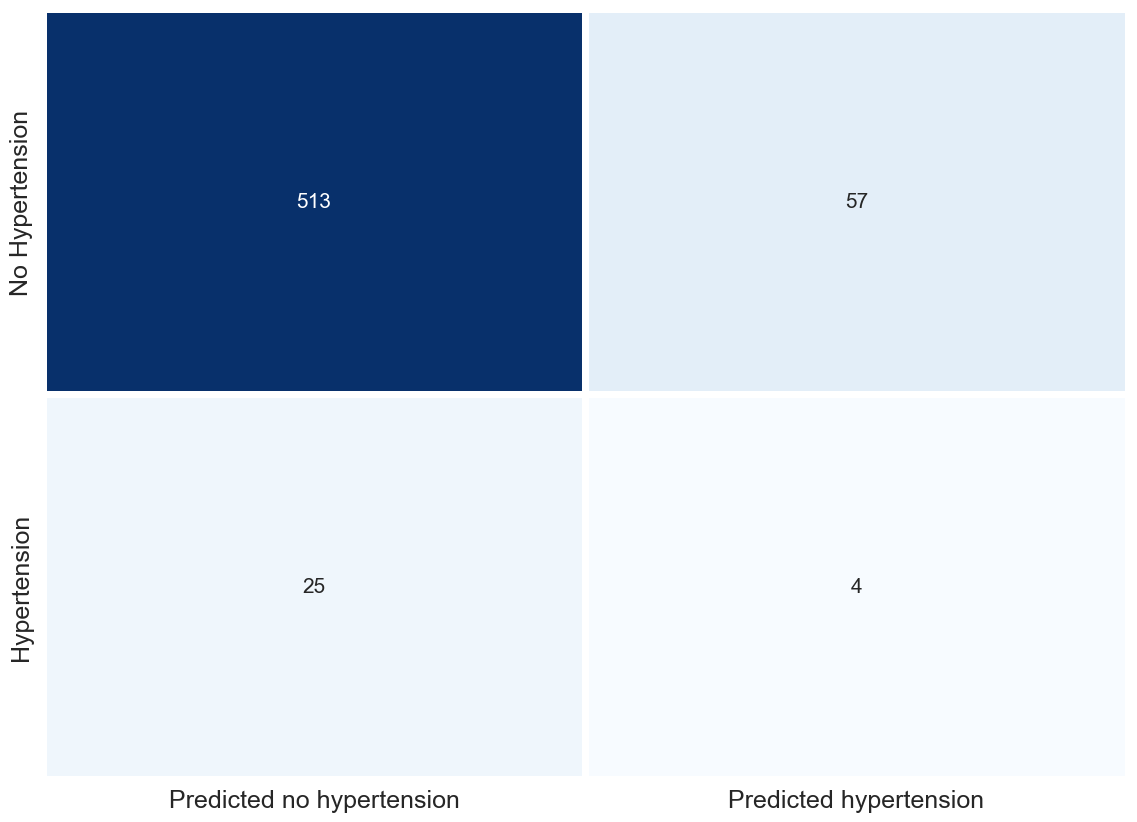

In [99]:
rf_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Hypertension', 'Hypertension'], xticklabels = ['Predicted no hypertension', 'Predicted hypertension'])


<font color=' red'><font size="5">as seen from our classification report,
- <font color=' red'><font size="4"> Recall for stroke = 1 is very bad, but for stroke = 0 is quite good. Opposite of the Decision Tree. 
-<font color=' red'><font size="4">However, accuracy for Random Forest is much better than Decision Tree.
  


<a id='4.6'></a>
# K Nearest Neighbours (KNN)


<font color=#5F9EA0><font size="4">In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). <br>
    If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 65, metric = 'minkowski', p = 2)
knn.fit(X_train_balanced, Y_train_balanced)
y_pred = knn.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78       570
           1       0.09      0.69      0.16        29

    accuracy                           0.65       599
   macro avg       0.53      0.67      0.47       599
weighted avg       0.93      0.65      0.75       599



<Axes: >

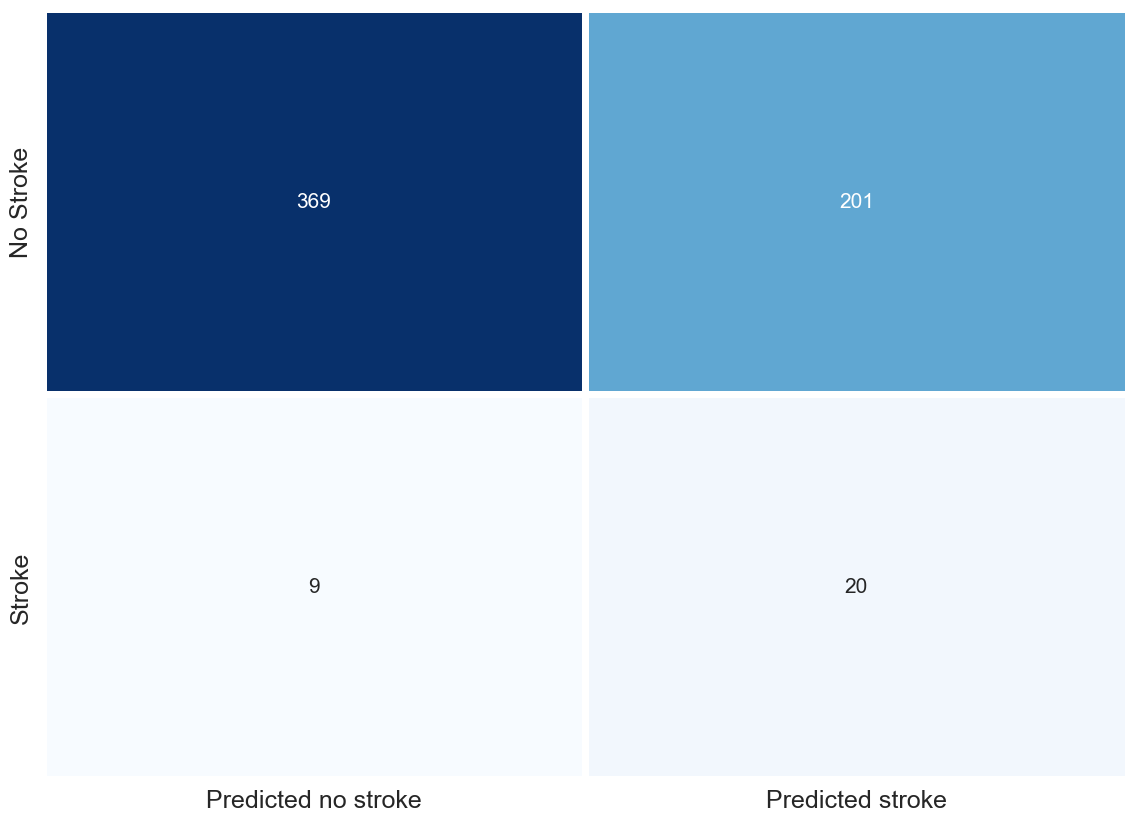

In [101]:
knn_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(knn_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])

<font color='blood red'><font size="5"> We use the square root of the number of samples we have which is sqrt(4280) = 65. </font><br><br>
<font color='blood red'><font size="5">As seen from our classification report,
- <font color='blood red'><font size="4"> our recall score for stroke = 1 is decent but for stroke = 0 recall is moderate.


<font color='blue'><font size="4">Again, we repeat but this time we use grid search to determine the best hyperparemter for recall

In [102]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, verbose=1, scoring='recall')
grid_search=grid.fit(X_train_balanced, Y_train_balanced)
print(grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_neighbors': 5}


In [103]:
knn = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
knn.fit(X_train_balanced, Y_train_balanced)
y_pred = knn.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89       570
           1       0.09      0.34      0.14        29

    accuracy                           0.80       599
   macro avg       0.53      0.58      0.52       599
weighted avg       0.92      0.80      0.85       599



<Axes: >

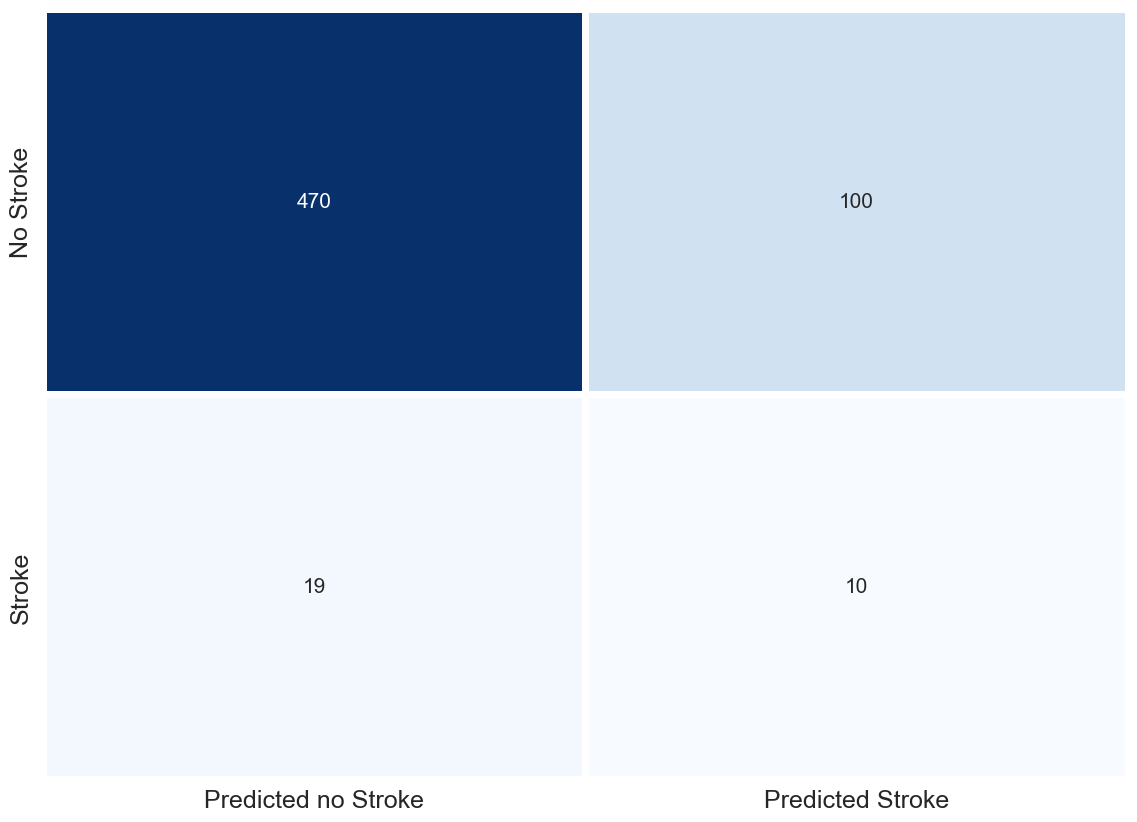

In [104]:
knn_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(knn_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Stroke', 'Stroke'], xticklabels = ['Predicted no Stroke', 'Predicted Stroke'])

<font color='blood red'><font size="5"> We use the predicted best n_neighbours hyperparameter value grid search found, which is 3. </font><br><br>
<font color='blood red'><font size="5">As seen from our classification report,
- <font color='blood red'><font size="4"> our recall score for stroke = 0 is decent but for stroke = 1 recall is bad


# Naive Bayes Classifier 

<font color=#5F9EA0><font size="4">In statistics, Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features. </font>

In [105]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(X_train_balanced, Y_train_balanced)
y_pred = gauss.predict(X_test)
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.70      0.81       570
           1       0.09      0.55      0.15        29

    accuracy                           0.69       599
   macro avg       0.53      0.63      0.48       599
weighted avg       0.93      0.69      0.78       599



## Permutation importance

<font color='green'><font size="4">Since GaussianNB does not have an in-built feature importance evaluation method, we use permutation importance </font>

In [106]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gauss, X_train_balanced, Y_train_balanced)

importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]
features = X_train_balanced_list
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. age (0.119676)
2. smoking_status_Cat (0.033144)
3. bmi (0.014823)
4. heart_disease (0.014823)
5. worktype_Cat (0.007739)
6. gender_Cat (0.006384)
7. avg_glucose_level (-0.000306)
8. hypertension (-0.001137)
9. Residence_type_Cat (-0.004198)
10. married_Cat (-0.009051)


## Confusion Matrix 

<Axes: >

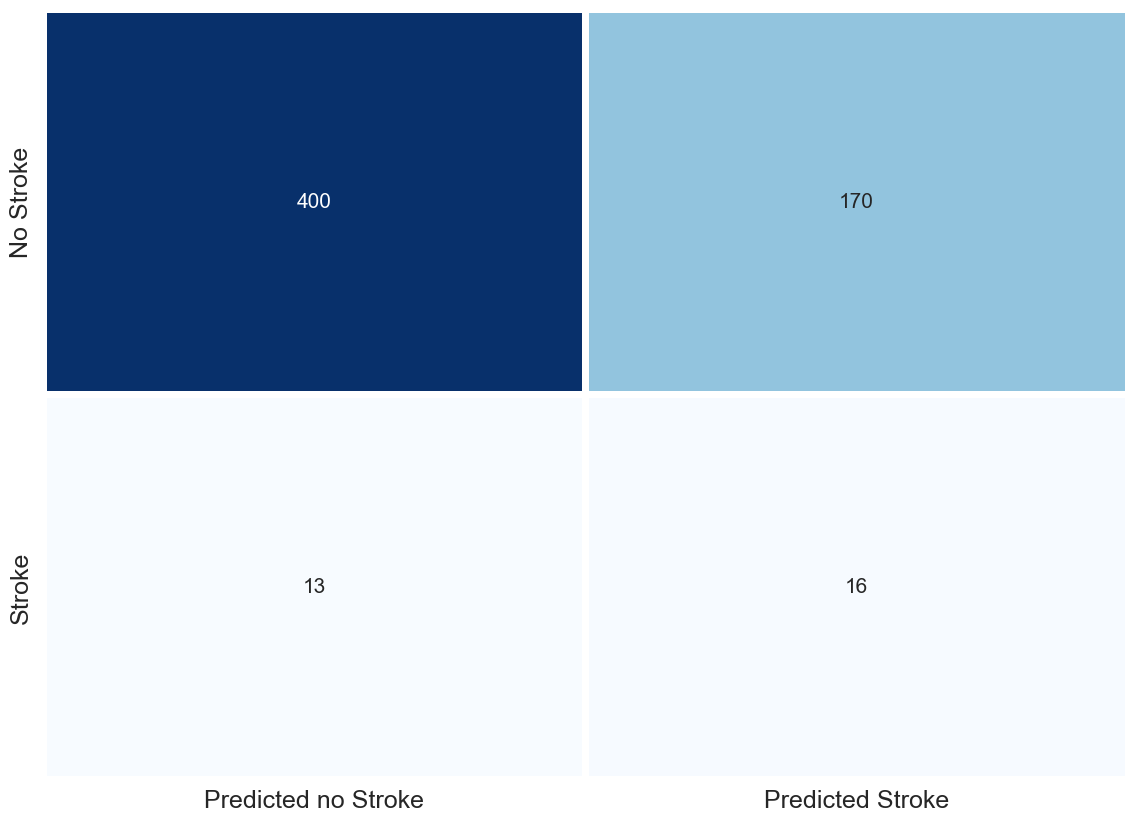

In [107]:
nb_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(nb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Stroke', 'Stroke'], xticklabels = ['Predicted no Stroke', 'Predicted Stroke'])

<font color='blood red'><font size="5">As seen from our classification report,
- <font color='blood red'><font size="4"> our recall score for stroke = 0 is decent and recall score for stroke = 1 is very good.


# eXtreme Gradient Boosting Classifier (XGBoost)


<font color=#B22222><font size="4">
Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; it usually outperforms random forest.<br><br>
<font color=#8B008B><font size="4">
XGBoost initially started as a research project by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC) group. Initially, it began as a terminal application which could be configured using a libsvm configuration file. It became well known in the ML competition circles after its use in the winning solution of the Higgs Machine Learning Challenge.

In [108]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = 22, max_depth = 5, objective = 'binary:logistic', eval_metric = 'logloss')
xgb.fit(X_train_balanced, Y_train_balanced)
y_pred = xgb.predict(X_test)
print(classification_report(Y_test, y_pred))

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(10))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = X_train_balanced.columns.to_list()[i]
f_imp3['importance'] = xgb.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:12].style.background_gradient(cmap = 'Blues')

<font color=#800080><font size="4">XGBoost picked up: <font color=#800000><font size="4">age, smoking_status, bmi and residence_type <font color=#800080><font size="4">as top 4 important features. <br>
<font color='orange'><font size="4"> However, the feature importance index are very close and cannot really tell us too much.

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train_balanced)

# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)

<font color=#800080><font size="4"> SHAP has picked up  <font color=#800000><font size="4">age, bmi and avg_glucose level <font color=#800080><font size="4">as the 3 most important features.</font>

## If we use RFE wrapper on XGBoost:

In [ ]:
rfe3 = RFE(estimator=xgb, n_features_to_select=4)
fit3 = rfe3.fit(X_train_balanced, Y_train_balanced)
print("Num Features: %s" % (fit3.n_features_))
features = {'Features': X_train_balanced_list,'Selected Features':fit3.support_ ,'Feature Ranking':fit3.ranking_}
rfe_df3 = pd.DataFrame(features)
rfe_df3

<font color=#800080><font size="4">RFE on XGBoost selected <font color='blue'><font size="4">age, heart_disease, married_status and smoking status.

In [ ]:
y_pred3 = fit3.predict(X_test)
print(classification_report(Y_test, y_pred3))

## Confusion Matrix of model using all featuers (No RFE):

In [ ]:
svc_cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(svc_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Stroke', 'Stroke'], xticklabels = ['Predicted no Stroke', 'Predicted Stroke'])

<font color='blood red'><font size="5">As seen from our classification report,
- <font color='blood red'><font size="4"> our recall score for Stroke = 0 is very good but very bad for Stroke = 1.
